# Trainer
Trainer is the highest-level encapsulation in Tianshou. It controls the training loop and the evaluation method. It also controls the interaction between the Collector and the Policy, with the ReplayBuffer serving as the media.

framework.svg



# Usages
In Tianshou v0.5.1, there are three types of Trainer. They are designed to be used in  on-policy training, off-policy training and offline training respectively. We will use on-policy trainer as an example and leave the other two for further reading.

## Pseudocode
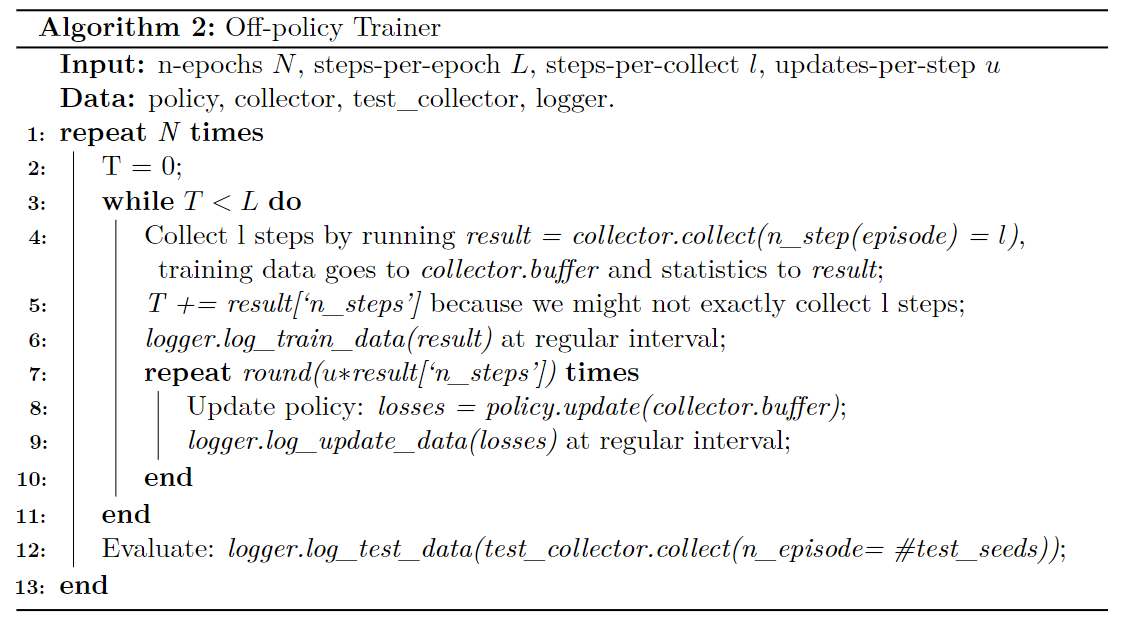

For the on-policy trainer, the main difference is that we clear the buffer after Line 10.

## Training without trainer
As we have learned the usages of the Collector and the Policy, it's possible that we write our own training logic.

First, let us create the instances of Environment, ReplayBuffer, Policy and Collector.

In [ ]:
import gymnasium as gym
import torch

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import PGPolicy
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor
from tianshou.trainer import OnpolicyTrainer

In [ ]:
train_env_num = 4
buffer_size = (
    2000  # Since REINFORCE is an on-policy algorithm, we don't need a very large buffer size
)

# Create the environments, used for training and evaluation
env = gym.make("CartPole-v1")
test_envs = DummyVectorEnv([lambda: gym.make("CartPole-v1") for _ in range(2)])
train_envs = DummyVectorEnv([lambda: gym.make("CartPole-v1") for _ in range(train_env_num)])

# Create the Policy instance
net = Net(
    env.observation_space.shape,
    hidden_sizes=[
        16,
    ],
)
actor = Actor(net, env.action_space.shape)
optim = torch.optim.Adam(actor.parameters(), lr=0.001)
policy = PGPolicy(
    actor=actor,
    optim=optim,
    dist_fn=torch.distributions.Categorical,
    action_space=env.action_space,
    action_scaling=False,
)

# Create the replay buffer and the collector
replaybuffer = VectorReplayBuffer(buffer_size, train_env_num)
test_collector = Collector(policy, test_envs)
train_collector = Collector(policy, train_envs, replaybuffer)

Now, we can try training our policy network. The logic is simple. We collect some data into the buffer and then we use the data to train our policy.

In [ ]:
train_collector.reset()
train_envs.reset()
test_collector.reset()
test_envs.reset()
replaybuffer.reset()
for i in range(10):
    evaluation_result = test_collector.collect(n_episode=10)
    print("Evaluation reward is {}".format(evaluation_result["rew"]))
    train_collector.collect(n_step=2000)
    # 0 means taking all data stored in train_collector.buffer
    policy.update(0, train_collector.buffer, batch_size=512, repeat=1)
    train_collector.reset_buffer(keep_statistics=True)

The evaluation reward doesn't seem to improve. That is simply because we haven't trained it for enough time. Plus, the network size is too small and REINFORCE algorithm is actually not very stable. Don't worry, we will solve this problem in the end. Still we get some idea on how to start a training loop.

## Training with trainer
The trainer does almost the same thing. The only difference is that it has considered many details and is more modular.

In [ ]:
train_collector.reset()
train_envs.reset()
test_collector.reset()
test_envs.reset()
replaybuffer.reset()

result = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=10,
    step_per_epoch=1,
    repeat_per_collect=1,
    episode_per_test=10,
    step_per_collect=2000,
    batch_size=512,
)
print(result)

# Further Reading
## Logger usages
Tianshou provides experiment loggers that are both tensorboard- and wandb-compatible. It also has a BaseLogger Class which allows you to self-define your own logger. Check the [documentation](https://tianshou.readthedocs.io/en/master/api/tianshou.utils.html#tianshou.utils.BaseLogger) for details.

## Learn more about the APIs of Trainers
[documentation](https://tianshou.readthedocs.io/en/master/api/tianshou.trainer.html)